# INM427 Neural Computing - Invidiual Project, DryBean Dataset Classification Task

Individual Project Description: You are asked to evaluate critically, compare and contrast two NECO methods applied to your choice of data set using Python and Jupyter notebook. NumPy, PyTorch, Scikit Learn and Skorch can be used. Tensorflow and Keras are not allowed.

Evaluation of an Multi Layered Perceptron (MLP) and Support Vector Machine (SVM) approaches. The training process for each has been optimised so both both final models produce an output of highest accuracy.

Tasks
- Load and visualise dataset, consider EDA and normalisation
- Build an optimise model parametres.
    - MLP gridSearch architecture (numeber of layers, number of neruons per layer, type of activation function), gridsearch tuneable hyperparameters while holding Architectural parameters.
    - SVM Tune varrious hyperparameters (kernel type, Box Constant).
    - Save Models
- Visualise accuracy metrics, training times, and nerual network architecture if possible.


Import necessary requirements and data

In [4]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import SGD
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import time
import pickle

import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split

In [5]:
path = "insert relevant path"
filename = "Dry_Bean_Dataset.xlsx"
df = pd.read_excel(path+filename)
df.head(5)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


(13611, 16)

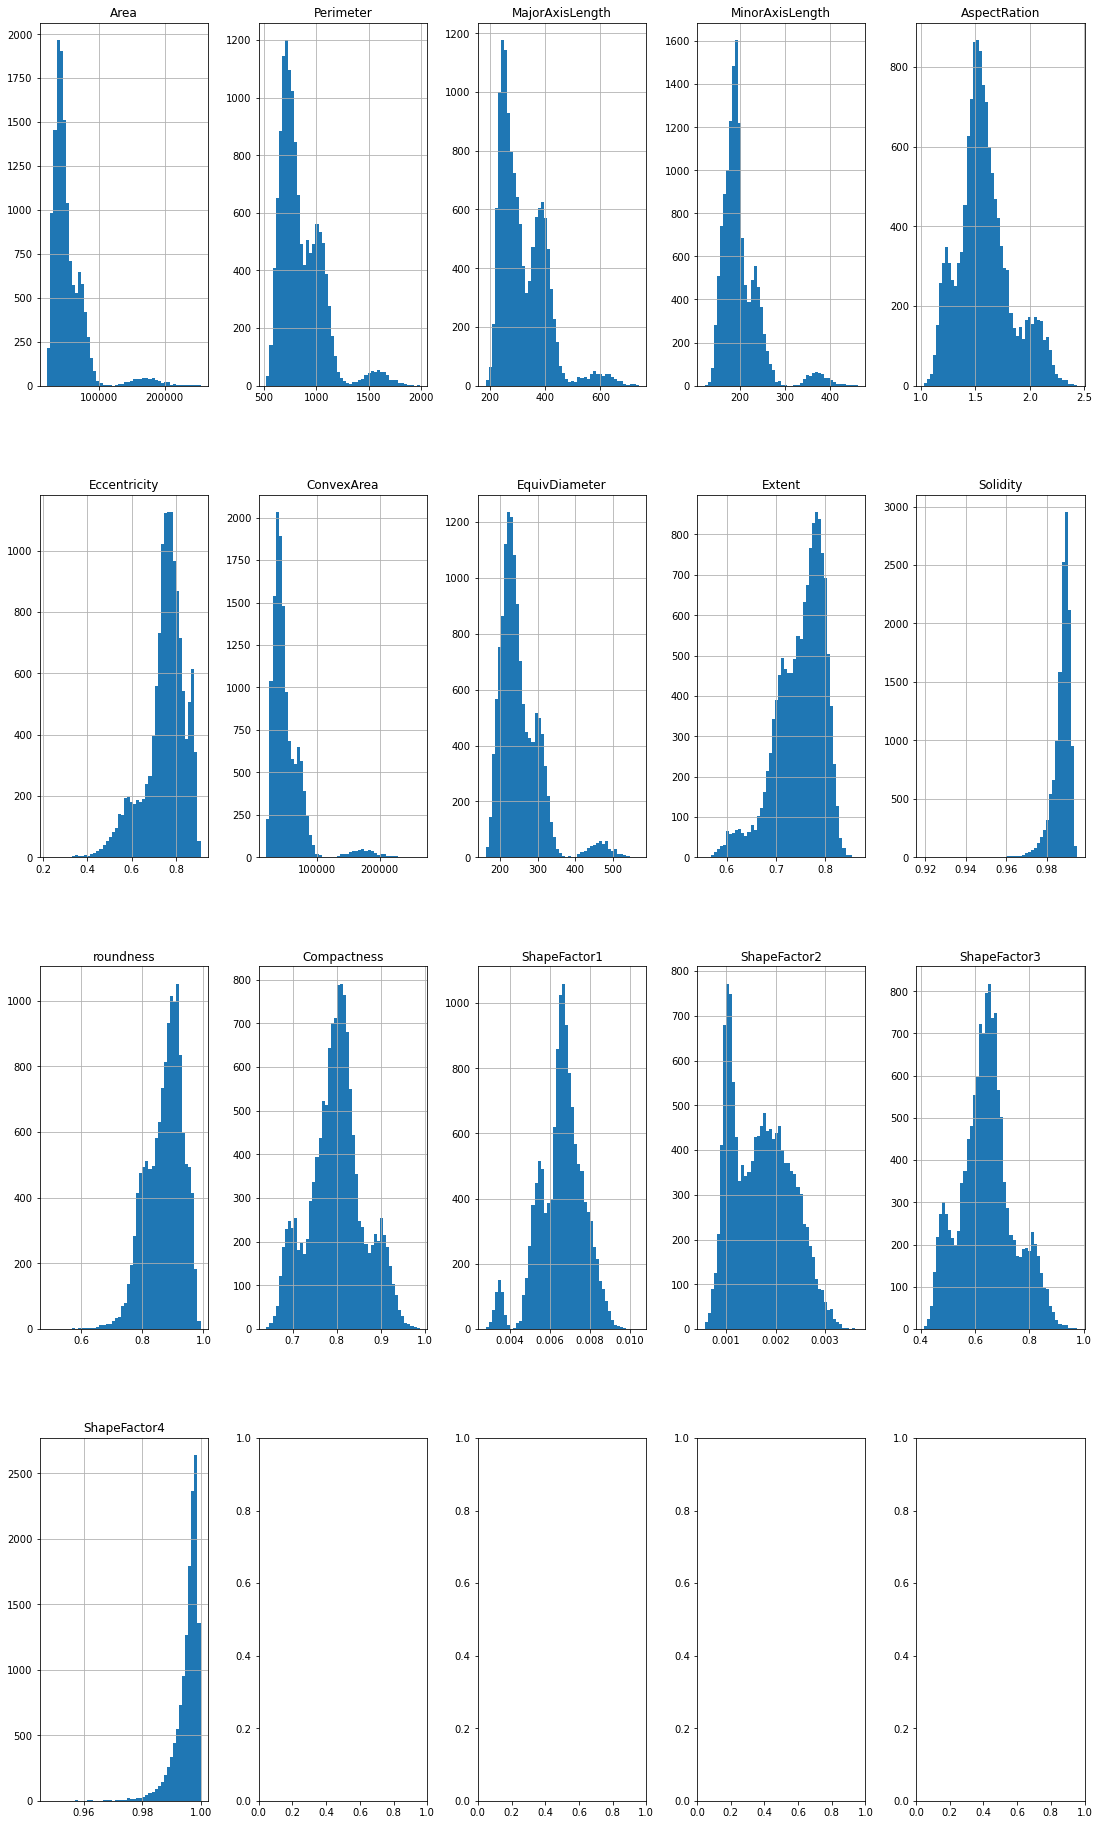

In [6]:
numeric_features = df.select_dtypes(include=[np.number])

numCols=numeric_features.shape[1]

#
fig, axisRows = plt.subplots(numCols//5+1, 5, figsize=(15, 25))
fig.tight_layout(pad=0.05)
i = 0
for axisCols in axisRows:
    for axis in axisCols:
        if (i<numCols):
            numeric_features.hist(column = numeric_features.columns[i], bins = 50, ax=axis)
            i = i+1
            
            
numeric_features.shape

Split data into train, validation, and test segments. Transform data into Tensors

In [7]:
#Spliting dataset into train = 80%, validation = 10%, and test = 10% 

from sklearn.model_selection import train_test_split

# Segmenting target varriable 'y', and features 'X'. Normalisation to range 0 to 1 is undertaken for all 'X' data.  
X = (df.iloc[:,:16])
X = (X.select_dtypes(include=[np.number])-X.select_dtypes(include=[np.number]).min())/(X.select_dtypes(include=[np.number]).max()-X.select_dtypes(include=[np.number]).min()) 
y = (df.iloc[:,16:])

# Encoding y to correct 
encoder = LabelEncoder()
encoder.fit(y)
yen = encoder.transform(y)
 
# Format transforming 'X'&'y' into tensors 
X = torch.tensor(X.values, dtype=torch.float32)
yen = torch.tensor(yen, dtype=torch.float32)
yen = yen.type(torch.LongTensor)


# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,yen, train_size=0.8, stratify=y)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
# Print Tensor Shape 
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

torch.Size([10888, 16])
torch.Size([10888])
torch.Size([1361, 16])
torch.Size([1361])
torch.Size([1362, 16])
torch.Size([1362])


C:\Users\jvernon\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(None, None)

## Model development and training
### MLP - Architecture and Hyperparaeters

Layer and Activation Function Selection.

First MLP will give us an idea as to the number of appropriate layers to use.

In [5]:
# MLP architecture with a flexible number of hidden layers, and tuneable activation function.

import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Defining MLP Architecture
class MLPArch(nn.Module):
    def __init__(self, input_size, n_layers=4,activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.acts = []
        for i in range(n_layers):
            self.layers.append(nn.Linear(input_size,16))
            self.acts.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.acts[-1])
        self.output = nn.Linear(16, 7)
 
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x)) 
        x = self.output(x)
        return x
    
# Stating tuneable parameters    
param_gridArch1 = {
    'module__n_layers':[2, 5, 10, 20],
    'module__activation': [ nn.ReLU, nn.Softsign,
                           nn.Sigmoid],
    'module__input_size': [X_train.shape[1]],
}

#Fitting MLP too Skorch
modelArch = NeuralNetClassifier(
    MLPArch,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.3,
    max_epochs=100,
    train_split=None,
)

#Using GridSearch to tune model architecture and search through combinations of MLP Layers and activation functions 
grid = GridSearchCV(estimator=modelArch, param_grid=param_gridArch1, scoring='accuracy', n_jobs=-1, cv=3)
grid_arch1 = grid.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.9815  0.3527
      2        0.4361  0.3869
      3        0.4122  0.3601
      4        0.3989  0.4052
      5        0.4019  0.4172
      6        0.4217  0.4003
      7        0.3311  0.3891
      8        0.3616  0.4051
      9        0.3957  0.3551
     10        0.4424  0.4301
     11        0.3938  0.3771
     12        0.4375  0.3836
     13        0.3856  0.4091
     14        0.4199  0.3486
     15        0.4932  0.4053
     16        0.5322  0.4337
     17        0.4530  0.3206
     18        0.4634  0.3466
     19        0.4380  0.3611
     20        0.4305  0.3821
     21        0.5181  0.3366
     22        0.4847  0.4351
     23        0.4149  0.3799
     24        0.4563  0.3481
     25        0.6671  0.3486
     26        0.5534  0.3921
     27        0.6096  0.3266
     28        0.5136  0.3376
     29        0.4463  0.3056
     30        0.5695  0.4133
     31        0.5931  0.3751
     32   

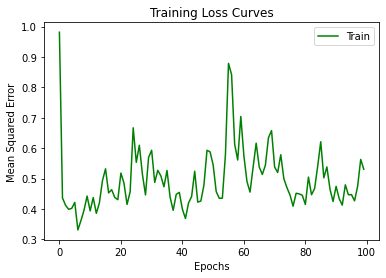

In [6]:
epochs = [i for i in range(len(grid_arch1.best_estimator_.history))]
train_loss = grid_arch1.best_estimator_.history[:,'train_loss']

plt.plot(epochs,train_loss,'g-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

In [7]:
print("Best: %f using %s" % (grid_arch1 .best_score_, grid_arch1 .best_params_))
means = grid_arch1.cv_results_['mean_test_score']
stds = grid_arch1.cv_results_['std_test_score']
params = grid_arch1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.794179 using {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 2}
0.404587 (0.203764) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 2}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 5}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 10}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 20}
0.794179 (0.041078) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 2}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 

In [8]:
print("Best: %f using %s" % (grid_arch1.best_score_, grid_arch1.best_params_))
means = grid_arch1.cv_results_['mean_test_score']
stds = grid_arch1.cv_results_['std_test_score']
params = grid_arch1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

MLPResArchL = pd.DataFrame(grid_arch1.cv_results_)
MLPResArchL = MLPResArchL[['params', 'mean_test_score', 'std_test_score']]
MLPResArchL = MLPResArchL.sort_values(by=['mean_test_score'], ascending=False)
print(MLPResArchL)

MLPResArchL.to_csv('MLPResArchL.csv', index=False)

Best: 0.794179 using {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 2}
0.404587 (0.203764) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 2}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 5}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 10}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__input_size': 16, 'module__n_layers': 20}
0.794179 (0.041078) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 2}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__input_size': 16, 'module__n_layers': 

Best performing number of layers is two. So we'll explore MLPs with arround two layers

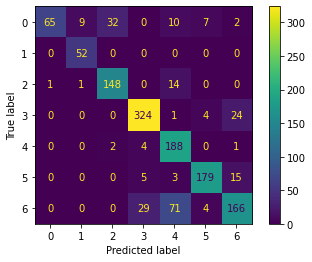

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = grid_arch1.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=grid_arch1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_arch1.classes_)
disp.plot()

plt.show()

Neuron, Hidden, Layer and Activation Function Selection

In [10]:
class MLPArch2(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation=nn.ReLU):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(activation())
        for i in range(len(hidden_layers)-1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.layers.append(activation())
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x
    
# explaim in critical (check back on Alex paper ) 
# Define the search space for the grid search
param_grid3 = {
    'module__hidden_layers': [[15, 8], [18, 12],[15,8,8],[12,3],[14,14,9],[16,16]],
    'module__input_size': [X_train.shape[1]],
    'module__output_size': [7],
    'module__activation': [ nn.ReLU, nn.Softsign, nn.Sigmoid],
}

modelArch3 = NeuralNetClassifier(
    MLPArch2,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    max_epochs=100,
    lr=0.3,
    train_split=None,
)

grid3 = GridSearchCV(estimator=modelArch3, param_grid=param_grid3, scoring='accuracy', n_jobs=-1, cv=3)
grid_arch3 = grid3.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7348  0.3431
      2        0.4683  0.3976
      3        0.4867  0.3966
      4        0.4128  0.4096
      5        0.4594  0.3656
      6        0.4255  0.3741
      7        0.4797  0.3931
      8        0.4088  0.3791
      9        0.4060  0.3286
     10        0.3965  0.3206
     11        0.3910  0.3219
     12        0.4637  0.3086
     13        0.4181  0.3106
     14        0.3843  0.3056
     15        0.3654  0.3146
     16        0.3711  0.3096
     17        0.3617  0.2966
     18        0.3643  0.3056
     19        0.3997  0.3351
     20        0.4183  0.3626
     21        0.4142  0.3236
     22        0.3845  0.3261
     23        0.3687  0.3086
     24        0.3915  0.3166
     25        0.3672  0.2916
     26        0.4587  0.2936
     27        0.4600  0.3066
     28        0.3730  0.3226
     29        0.3425  0.3276
     30        0.4224  0.3416
     31        0.4091  0.3336
     32   

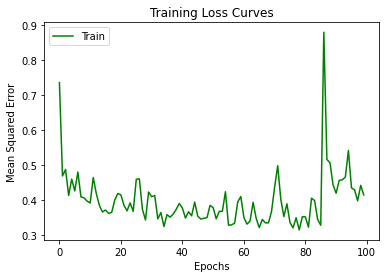

In [11]:
epochs = [i for i in range(len(grid_arch3.best_estimator_.history))]
train_loss = grid_arch3.best_estimator_.history[:,'train_loss']

plt.plot(epochs,train_loss,'g-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

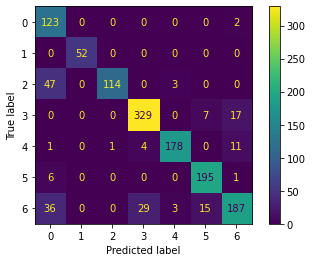

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = grid_arch3.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=grid_arch3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid_arch3.classes_)
disp.plot()

plt.show()

In [13]:
print("Best: %f using %s" % (grid_arch3.best_score_, grid_arch3.best_params_))
means = grid_arch3.cv_results_['mean_test_score']
stds = grid_arch3.cv_results_['std_test_score']
params = grid_arch3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

MLPResArch = pd.DataFrame(grid_arch3.cv_results_)
MLPResArch = MLPResArch[['params', 'mean_test_score', 'std_test_score']]
MLPResArch = MLPResArch.sort_values(by=['mean_test_score'], ascending=False)
print(MLPResArch)

MLPResArch.to_csv('MLPResArch.csv', index=False)

Best: 0.895297 using {'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__hidden_layers': [15, 8], 'module__input_size': 16, 'module__output_size': 7}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__hidden_layers': [18, 12], 'module__input_size': 16, 'module__output_size': 7}
0.404272 (0.203073) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__hidden_layers': [15, 8, 8], 'module__input_size': 16, 'module__output_size': 7}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7}
0.260562 (0.000164) with: {'module__activation': <class 'torch.nn.modules.activation.ReLU'>, 'module__

In [14]:
MLPResArch = pd.DataFrame(grid_arch3.cv_results_)
MLPResArch = MLPResArch[['params', 'mean_test_score', 'std_test_score']]
MLPResArch = MLPResArch.sort_values(by=['mean_test_score'], ascending=False)
print(MLPResArch)

                                               params  mean_test_score  \
9   {'module__activation': <class 'torch.nn.module...         0.895297   
6   {'module__activation': <class 'torch.nn.module...         0.872888   
7   {'module__activation': <class 'torch.nn.module...         0.799775   
11  {'module__activation': <class 'torch.nn.module...         0.795092   
8   {'module__activation': <class 'torch.nn.module...         0.512859   
14  {'module__activation': <class 'torch.nn.module...         0.507266   
12  {'module__activation': <class 'torch.nn.module...         0.477642   
15  {'module__activation': <class 'torch.nn.module...         0.429112   
2   {'module__activation': <class 'torch.nn.module...         0.404272   
10  {'module__activation': <class 'torch.nn.module...         0.348264   
16  {'module__activation': <class 'torch.nn.module...         0.260562   
13  {'module__activation': <class 'torch.nn.module...         0.260562   
0   {'module__activation': <class 'tor

## MLP Hyperparameter Optimisation

In [15]:
# Define the MLP model
class MLPHype(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation=nn.ReLU):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(activation())
        for i in range(len(hidden_layers)-1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.layers.append(activation())
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x
    
    
# Define the grid search parameters
params = {
    'module__hidden_layers': [[12,3]],
    'module__output_size': [7],
    'module__input_size': [X_train.shape[1]],
    'lr': [0.3,0.1,0.01],
    'optimizer__weight_decay': [0.001, 0.0001],
    'optimizer__momentum': [0.8, 0.9],
    'module__activation': [nn.Softsign]
}

# Create the MLP model and wrap it in a Skorch classifier
mlp = NeuralNetClassifier(
    MLPHype,
    max_epochs=100,
    optimizer=torch.optim.SGD,
    criterion=nn.CrossEntropyLoss,
    train_split=None,
    verbose=1
)

# Create the grid search object and fit the data
gs = GridSearchCV(mlp, params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)

# Print the best score and parameters
print("Best score: %f" % gs.best_score_)
print("Best parameters: ", gs.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        1.6775  0.2755
      2        1.1931  0.2896
      3        1.0334  0.4001
      4        0.9380  0.5582
      5        0.7554  0.3726
      6        0.5674  1.1020
      7        0.5090  0.9819
      8        0.4774  0.3852
      9        0.4541  0.3881
     10        0.4343  0.3681
     11        0.4168  0.3066
     12        0.4026  0.3066
     13        0.3902  0.3266
     14        0.3790  0.3371
     15        0.3692  0.3306
     16        0.3605  0.3176
     17        0.3518  0.4061
     18        0.3447  0.3311
     19        0.3386  0.2791
     20        0.3330  0.2816
     21        0.3277  0.2616
     22        0.3231  0.2662
     23        0.3192  0.3116
     24        0.3155  0.2956
     25        0.3123  0.3046
     26        0.3092  0.2792
     27        0.3064  0.2690
     28        0.3039  0.3291
     29        0.3014  0.3376
     30        0.2992  0.2616
     31        0.2970  0.3909
     32   

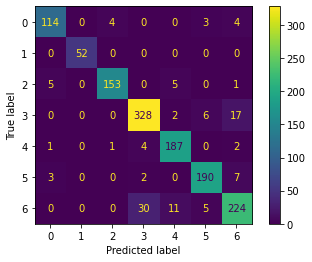

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = gs.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs.classes_)
disp.plot()

plt.show()

In [17]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
MLPResHype = pd.DataFrame(gs.cv_results_)
MLPResHype = MLPResHype[['params', 'mean_test_score', 'std_test_score']]
MLPResHype = MLPResHype.sort_values(by=['mean_test_score'], ascending=False)
print(MLPResHype)

MLPResHype.to_csv('MLPResHype.csv', index=False)

Best: 0.912839 using {'lr': 0.1, 'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.0001}
0.869395 (0.036641) with: {'lr': 0.3, 'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.001}
0.899981 (0.014382) with: {'lr': 0.3, 'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.0001}
0.850568 (0.009826) with: {'lr': 0.3, 'module__activation': <class 'torch.nn.modules.activation.Softsign'>, 'module__hidden_layers': [12, 3], 'module__input_size': 16, 'module__output_size': 7, 'optimizer__momentum': 0.9, 'optimizer__w

In [18]:
import pickle

with open('MLPHypOptimised.pkl', 'wb') as f:
    pickle.dump(gs, f)

In [19]:
import pickle

with open('MLPHypOptimised.pkl', 'rb') as f:
    MLP = pickle.load(f)

## SVM Hyperparameter Optimisation

### Tune Hyperparameters

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# define the range of hyperparameters to search over
param_grid = {'C': [10, 50, 100],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              #'degree': [2, 3, 4],
              #'gamma': ['scale', 'auto', 0.1, 1, 10],
              #'class_weight': [None, 'balanced'],
              }

# create an SVM object
svm = SVC()

# create a GridSearchCV object
SVC1 = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)

# fit the GridSearchCV object to the data
SVC1.fit(X_train, y_train)

# print the best hyperparameters
print(SVC1.best_params_)

{'C': 50, 'kernel': 'rbf'}


In [22]:
print("Best: %f using %s" % (SVC1.best_score_, SVC1.best_params_))
means = SVC1.cv_results_['mean_test_score']
stds = SVC1.cv_results_['std_test_score']
params = SVC1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

SVMResHype = pd.DataFrame(SVC1.cv_results_)
SVMResHype = SVMResHype[['params', 'mean_test_score', 'std_test_score']]
SVMResHype = SVMResHype.sort_values(by=['mean_test_score'], ascending=False)
print(SVMResHype)

SVMResHype.to_csv('SVMResHype.csv', index=False)

Best: 0.929004 using {'C': 50, 'kernel': 'rbf'}
0.927075 (0.005146) with: {'C': 10, 'kernel': 'linear'}
0.927902 (0.003502) with: {'C': 10, 'kernel': 'poly'}
0.927626 (0.003719) with: {'C': 10, 'kernel': 'rbf'}
0.578159 (0.005530) with: {'C': 10, 'kernel': 'sigmoid'}
0.929004 (0.005136) with: {'C': 50, 'kernel': 'linear'}
0.927902 (0.003734) with: {'C': 50, 'kernel': 'poly'}
0.929004 (0.002838) with: {'C': 50, 'kernel': 'rbf'}
0.512305 (0.016869) with: {'C': 50, 'kernel': 'sigmoid'}
0.928453 (0.005023) with: {'C': 100, 'kernel': 'linear'}
0.927718 (0.004418) with: {'C': 100, 'kernel': 'poly'}
0.928453 (0.003286) with: {'C': 100, 'kernel': 'rbf'}
0.521492 (0.004712) with: {'C': 100, 'kernel': 'sigmoid'}
                             params  mean_test_score  std_test_score
6        {'C': 50, 'kernel': 'rbf'}         0.929004        0.002838
4     {'C': 50, 'kernel': 'linear'}         0.929004        0.005136
10      {'C': 100, 'kernel': 'rbf'}         0.928453        0.003286
8    {'C': 1

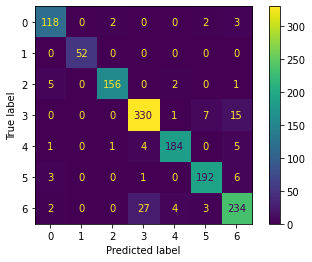

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = SVC1.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=SVC1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SVC1.classes_)
disp.plot()

plt.show()

In [24]:
import pickle
with open('SVMoptimised.pkl', 'wb') as f:
    pickle.dump(SVC1, f)

In [25]:
with open('SVMoptimised.pkl', 'rb') as f:
    SVM1 = pickle.load(f)

# Final Training on combines training and validation data 

In [6]:
# training and validation variables are combined

X_train = torch.cat((X_train, X_valid), dim=0)
y_train = torch.cat((y_train, y_valid), dim=0)

### Final MLP

In [60]:
# Define the MLP model
class MLPF(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, activation=nn.ReLU):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))
        self.layers.append(activation())
        for i in range(len(hidden_layers)-1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.layers.append(activation())
        self.output = nn.Linear(hidden_layers[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x
    
# Define the grid search parameters

params = {
    'module__hidden_layers': [[12,3]],
    'module__output_size': [7],
    'module__input_size': [X_train.shape[1]],
    'lr': [0.1],
    'optimizer__weight_decay': [0.0001],
    'optimizer__momentum': [0.8],
    'module__activation': [nn.Softsign]
}


# Create the MLP model and wrap it in a Skorch classifier
FMLP = NeuralNetClassifier(
    MLPF,
    module__hidden_layers=[12,3],
    module__output_size= 7,
    module__input_size=X_train.shape[1],
    lr= 0.1,
    optimizer__weight_decay=0.0001,
    optimizer__momentum=0.8,
    module__activation=nn.Softsign,
    max_epochs=200,
    optimizer=torch.optim.SGD,
    criterion=nn.CrossEntropyLoss,
    train_split=None,
    verbose=1
    )


# Create the grid search object and fit the data
#FMLP = GridSearchCV(mlp, params, cv=5, scoring='accuracy', n_jobs=-1)


MLP_train_times = []
MLP_inference_times = []
MLP_inference_time_1_predict = []


start_time = time.time()
FMLP.fit(X_train,y_train)
end_time = time.time()
train_time = end_time - start_time
MLP_train_times.append(train_time)
    
start_time = time.time()
y_pred = FMLP.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time
MLP_inference_times.append(inference_time)

start_time = time.time()
y_pred = FMLP.predict(X_test[0:1])
end_time = time.time()
inference_time_1 = end_time - start_time
MLP_inference_time_1_predict.append(inference_time_1)


  epoch    train_loss     dur
-------  ------------  ------
      1        1.7882  0.2139
      2        1.1454  0.1990
      3        0.7237  0.1940
      4        0.5799  0.2175
      5        0.5291  0.2091
      6        0.5033  0.2500
      7        0.4845  0.2121
      8        0.4724  0.2021
      9        0.4631  0.2098
     10        0.4538  0.2457
     11        0.4427  0.2636
     12        0.4315  0.2720
     13        0.4193  0.2804
     14        0.4078  0.3006
     15        0.3986  0.3236
     16        0.3896  0.3491
     17        0.3805  0.3076
     18        0.3713  0.3002
     19        0.3634  0.3086
     20        0.3561  0.4141
     21        0.3493  0.3881
     22        0.3433  0.3431
     23        0.3380  0.3226
     24        0.3329  0.3537
     25        0.3284  0.3181
     26        0.3238  0.2837
     27        0.3194  0.2721
     28        0.3154  0.2646
     29        0.3118  0.2717
     30        0.3085  0.2971
     31        0.3058  0.3152
     32   

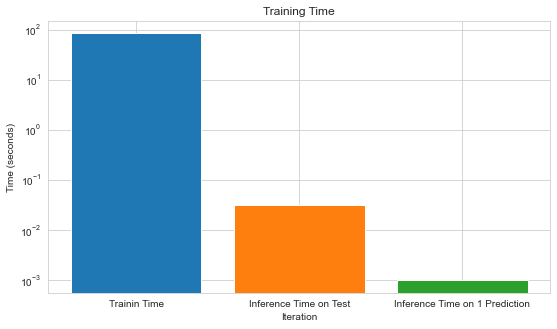

In [48]:
# capture training time

plt.figure(figsize=(9,5))
plt.bar(['Trainin Time'],MLP_train_times)
plt.bar(['Inference Time on Test'],MLP_inference_times)
plt.bar(['Inference Time on 1 Prediction'],MLP_inference_time_1_predict)
plt.title('Training Time')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.yscale('log',base=10) 
plt.show()

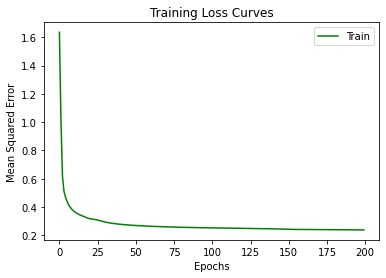

In [26]:
epochs = [i for i in range(len(FMLP.history))]
train_loss = FMLP.history[:,'train_loss']

plt.plot(epochs,train_loss,'g-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

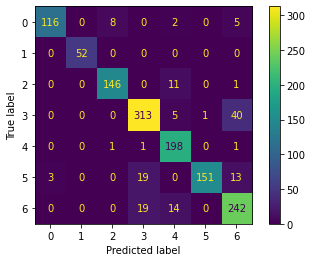

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = FMLP.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=FMLP.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=FMLP.classes_)

disp.plot()

plt.show()

In [28]:
test_score = FMLP.score(X_test, y_test)
print('Test accuracy:', test_score)

print("Best: %f using %s" % (test_score, FMLP.get_params))




Test accuracy: 0.8942731277533039
Best: 0.894273 using <bound method NeuralNet.get_params of <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLPF(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=12, bias=True)
      (1): Softsign()
      (2): Linear(in_features=12, out_features=3, bias=True)
      (3): Softsign()
    )
    (output): Linear(in_features=3, out_features=7, bias=True)
  ),
)>


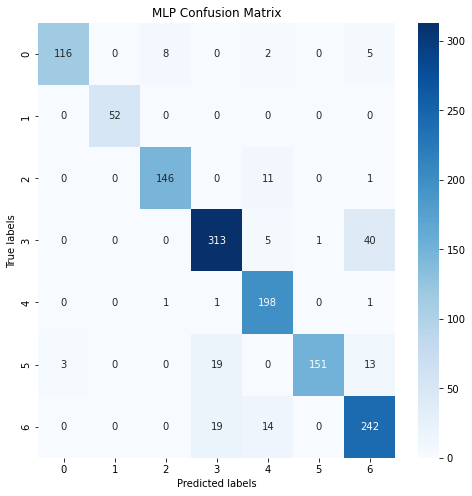

In [29]:
y_pred_mlp = FMLP.predict(X_test)


# Assuming you have the true labels and predicted labels stored in variables y_true and y_pred, respectively
cm = confusion_matrix(y_test, y_pred_mlp)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('MLP Confusion Matrix')

plt.show()

In [ ]:
with open('FMLP.pkl', 'wb') as f:
    pickle.dump(FMLP, f)

### Final SVM

In [61]:
from sklearn.svm import SVC


# define the range of hyperparameters to search over
param_grid = {'C': [50],
              'kernel': ['rbf'],
              #'loss':['hinge']
              #'degree': [2, 3, 4],
              #'gamma': ['scale', 'auto', 0.1, 1, 10],
              #'class_weight': [None, 'balanced'],
              }

# create an SVM object
svm = SVC()

loss_history = []

# create a GridSearchCV object
FSVM = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1)

# fit the GridSearchCV object to the data

SVM_train_times = []
SVM_inference_times = []
SVM_inference_times_1_predict = []

start_time = time.time()
FSVM.fit(X_train, y_train)
end_time = time.time()
train_time = end_time - start_time
SVM_train_times.append(train_time)
    
start_time = time.time()
y_pred = FSVM.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time
SVM_inference_times.append(inference_time)

start_time = time.time()
y_pred = FSVM.predict(X_test[0:1])
end_time = time.time()
inference_time_1 = end_time - start_time
SVM_inference_times_1_predict.append(inference_time_1)

# print the best hyperparameters
print(FSVM.best_params_)

{'C': 50, 'kernel': 'rbf'}


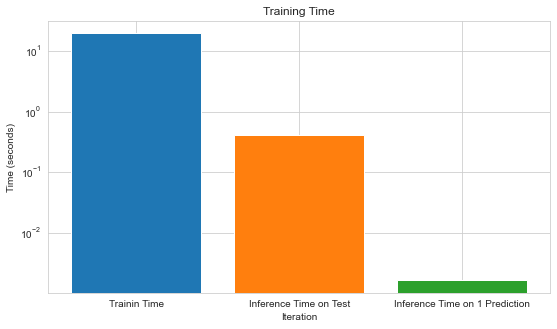

Best score: 0.928546
Best parameters:  {'C': 50, 'kernel': 'rbf'}


In [51]:
plt.figure(figsize=(9,5))
plt.bar(['Trainin Time'],SVM_train_times)
plt.bar(['Inference Time on Test'],SVM_inference_times)
plt.bar(['Inference Time on 1 Prediction'],SVM_inference_times_1_predict)
plt.title('Training Time')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.yscale('log',base=10) 
plt.show()

# Print the best score and parameters
print("Best score: %f" % FSVM.best_score_)
print("Best parameters: ", FSVM.best_params_)
# Final round of testing on train and val data 

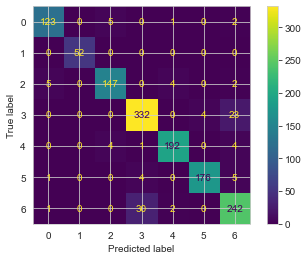

                       params  mean_test_score  std_test_score
0  {'C': 50, 'kernel': 'rbf'}         0.928546        0.005943


In [52]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = FSVM.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=FSVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=FSVM.classes_)
disp.plot()

plt.show()



FSVMRes = pd.DataFrame(FSVM.cv_results_)
FSVMRes = FSVMRes[['params', 'mean_test_score', 'std_test_score']]
FSVMRes = FSVMRes.sort_values(by=['mean_test_score'], ascending=False)
print(FSVMRes)

FSVMRes.to_csv('FSVMRes.csv', index=False)


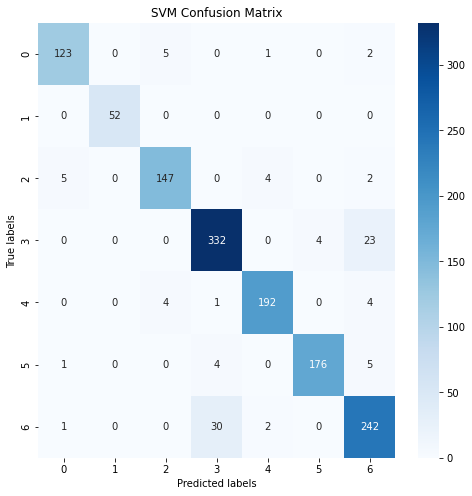

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred_svm = FSVM.predict(X_test)

# Assuming you have the true labels and predicted labels stored in variables y_true and y_pred, respectively
cm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')

plt.show()

In [32]:
with open('FSVM.pkl', 'wb') as f:
    pickle.dump(FSVM, f)

## Accuracy Metrics for both MLP and SVM models

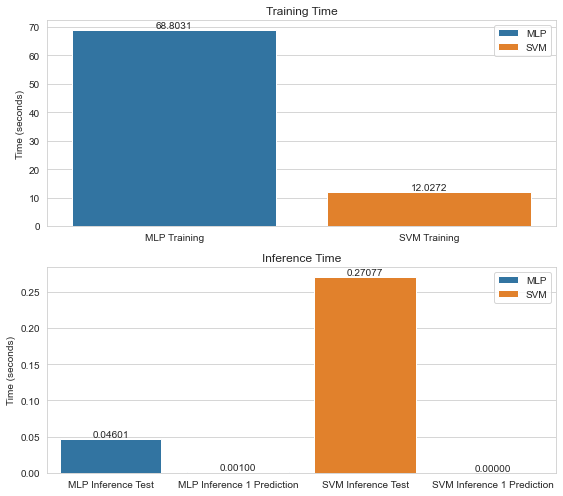

In [62]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create pandas DataFrames for training and inference data
training_data = {
    'Model': ['MLP Training', 'SVM Training'],
    'Time (seconds)': [MLP_train_times[0], SVM_train_times[0]],
    'Category': ['MLP', 'SVM']
}
inference_data = {
    'Model': ['MLP Inference Test', 'MLP Inference 1 Prediction', 'SVM Inference Test', 'SVM Inference 1 Prediction'],
    'Time (seconds)': [MLP_inference_times[0], MLP_inference_time_1_predict[0], SVM_inference_times[0], SVM_inference_times_1_predict[0]],
    'Category': ['MLP', 'MLP', 'SVM', 'SVM']
}

df_training = pd.DataFrame(training_data)
df_inference = pd.DataFrame(inference_data)

# Set the figure size
plt.figure(figsize=(8, 7))

# Create the bar plot for training data using seaborn
sns.set_style('whitegrid')
ax1 = plt.subplot(211)
sns.barplot(x='Model', y='Time (seconds)', hue='Category', data=df_training, ax=ax1, dodge=False)
ax1.set_title('Training Time')
ax1.set_xlabel('')
ax1.set_ylabel('Time (seconds)')
ax1.get_legend().set_title('')

# Add value labels to the bars
for index, row in df_training.iterrows():
    ax1.text(index, row['Time (seconds)'], "{:.4f}".format(row['Time (seconds)']),
             ha='center', va='bottom', fontsize=10)

# Create the bar plot for inference data using seaborn
ax2 = plt.subplot(212)
sns.barplot(x='Model', y='Time (seconds)', hue='Category', data=df_inference, ax=ax2, dodge=False)
ax2.set_title('Inference Time')
ax2.set_xlabel('')
ax2.set_ylabel('Time (seconds)')
ax2.get_legend().set_title('')

# Add value labels to the bars
for index, row in df_inference.iterrows():
    ax2.text(index, row['Time (seconds)'], "{:.5f}".format(row['Time (seconds)']),
             ha='center', va='bottom', fontsize=10)

# Remove log scale from both subplots
ax1.set_yscale('linear')
ax2.set_yscale('linear')

plt.tight_layout()
plt.show()

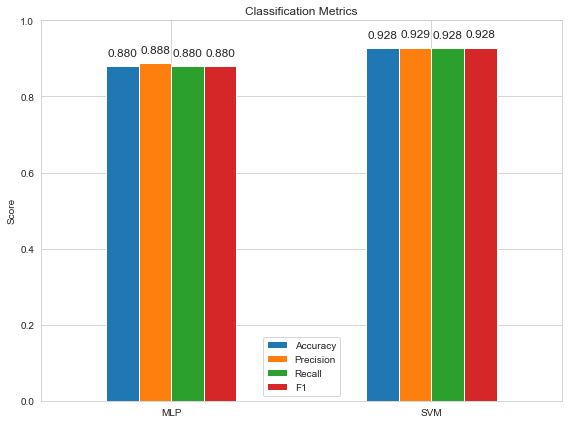

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# make predictions on the test set
y_pred_mlp = FMLP.predict(X_test)

# calculate classification metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')
# train an SVM classifier

# make predictions on the test set
y_pred_svm = FSVM.predict(X_test)

# calculate classification metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')

# create a pandas dataframe with the results
dfacc = pd.DataFrame({
    'Classifier': ['MLP', 'SVM'],
    'Accuracy': [accuracy_mlp, accuracy_svm],
    'Precision': [precision_mlp, precision_svm],
    'Recall': [recall_mlp, recall_svm],
    'F1': [f1_mlp, f1_svm],
})

# save the dataframe to a csv file
dfacc.to_csv('classification_metrics.csv', index=False)

sns.set_style('whitegrid')
ax = dfacc.plot(kind='bar', figsize=(8, 6), rot=0)
ax.set_title('Classification Metrics')
ax.set_ylabel('Score')
ax.set_ylim([0, 1])  # set y-limits to 0 and 1

for p in ax.containers:
    ax.bar_label(p, label_type='edge', fontsize=12, padding=8, labels=[f"{val:.3f}" for val in p.datavalues])  # format the labels to 2 decimal places

ax.set_xticklabels(dfacc['Classifier'])  # set x-labels to the model names

plt.tight_layout()
plt.savefig('classification_metrics.png')
plt.show()

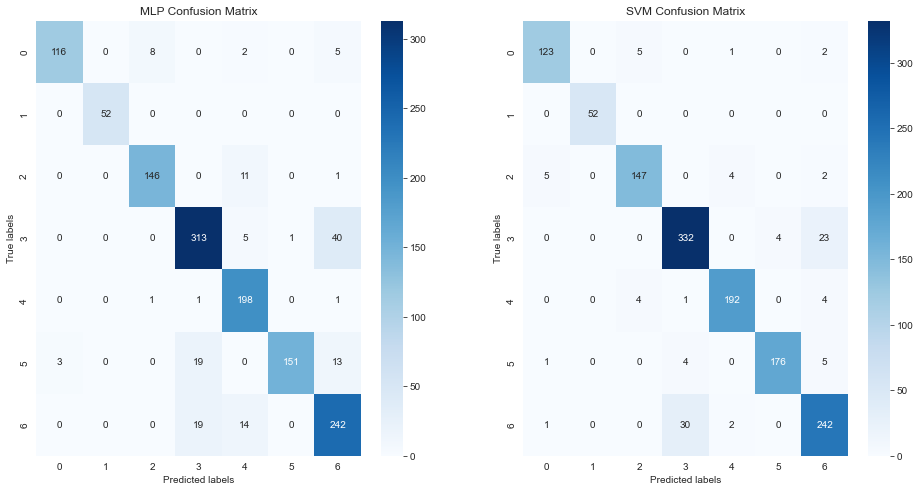

In [35]:
# Create the subplots
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

# Plot the MLP confusion matrix in the first subplot
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='g', ax=axs[0])
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_title('MLP Confusion Matrix')

# Plot the SVM confusion matrix in the second subplot
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='g', ax=axs[1])
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')
axs[1].set_title('SVM Confusion Matrix')

plt.show()

C:\Users\jvernon\AppData\Local\Temp\ipykernel_34124\308431168.py:41: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


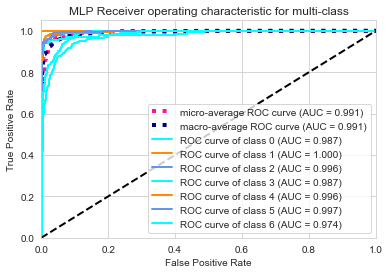

In [36]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import numpy as np

# Define your model and make predictions on your test set
model = FMLP
X_test1 = X_test
y_test1 = y_test # your test set labels (as a tensor)
y_score = model.predict_proba(X_test1)

# Convert tensors to numpy arrays
X_test1 = X_test1.detach().numpy()
y_test1 = y_test1.detach().numpy()

# Binarize the labels
n_classes = y_score.shape[1]
y_test_bin = label_binarize(y_test1, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


C:\Users\jvernon\AppData\Local\Temp\ipykernel_34124\547316374.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


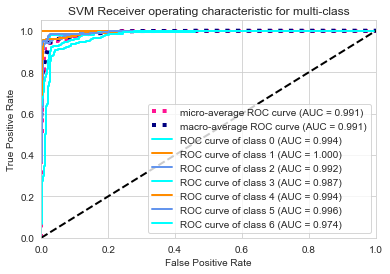

In [37]:
model = FSVM # your trained model
X_test1 = X_test # your test set features
y_test1 = y_test # your test set labels
y_score = model.decision_function(X_test)

# Binarize the labels
n_classes = len(np.unique(y_test1))
y_test1 = label_binarize(y_test1, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

In [38]:
bestSvm = FSVM.best_estimator_

print("Number of support vectors for each class:", bestSvm.n_support_)


Number of support vectors for each class: [178   7 203 507 168 186 641]


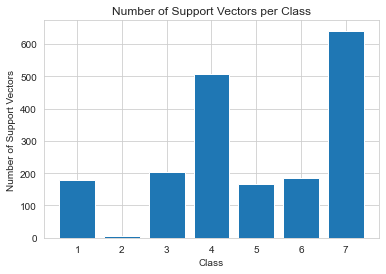

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Get the number of support vectors for each class
n_support = bestSvm.n_support_

# Plot the number of support vectors for each class
plt.bar(np.arange(len(n_support)), n_support)
plt.xticks(np.arange(len(n_support)), np.arange(1, len(n_support)+1))
plt.xlabel("Class")
plt.ylabel("Number of Support Vectors")
plt.title("Number of Support Vectors per Class")
plt.show()

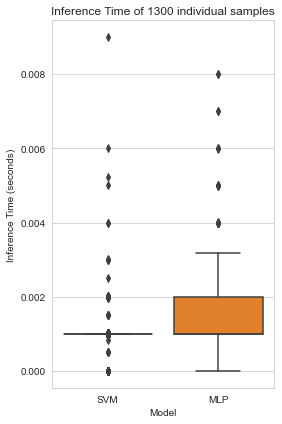

In [55]:
# Define the number of data points to test
num_data_points = 1300

# Initialize empty lists to store inference times
SVM_inference_times = []
FMLP_inference_times = []

# Generate random indices to select data points from the test set
random_indices = np.random.choice(len(X_test), num_data_points, replace=False)

# Loop over the selected data points and run inference tests for each model
for i in range(num_data_points):
    data_point = X_test[random_indices[i]]

    # SVM
    start_time = time.time()
    y_pred = FSVM.predict(data_point.reshape(1, -1))
    end_time = time.time()
    inference_time = end_time - start_time
    SVM_inference_times.append(inference_time)

    # MLP
    start_time = time.time()
    y_pred = FMLP.predict(data_point.reshape(1, -1))
    end_time = time.time()
    inference_time = end_time - start_time
    FMLP_inference_times.append(inference_time)

# Create pandas DataFrame for inference data
inference_data = {
    'Model': ['SVM', 'MLP'],
    'Inference Time (seconds)': [SVM_inference_times, FMLP_inference_times]
}

df_inference = pd.DataFrame(inference_data)
df_inference = df_inference.explode('Inference Time (seconds)')

# Set the figure size
plt.figure(figsize=(4, 6))

# Create the box plot for inference data using seaborn
sns.set_style('whitegrid')
sns.boxplot(x='Model', y='Inference Time (seconds)', data=df_inference)

plt.title('Inference Time of 1300 individual samples')
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')

plt.tight_layout()
plt.show()


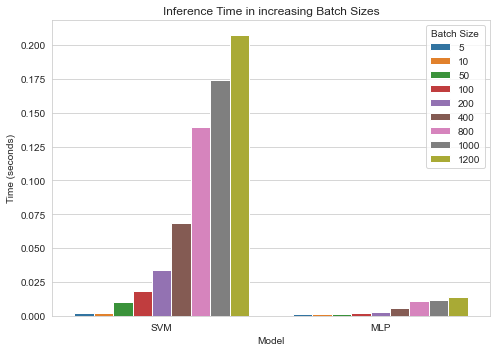

In [59]:
# Define the batch sizes to test
batch_sizes = [5, 10, 50, 100, 200, 400, 800, 1000, 1200]

# Initialize empty lists to store inference times
SVM_inference_times = [[] for _ in range(len(batch_sizes))]
FMLP_inference_times = [[] for _ in range(len(batch_sizes))]

# Run inference tests for each batch size
for i, batch_size in enumerate(batch_sizes):
    # SVM
    start_time = time.time()
    y_pred = FSVM.predict(X_test[:batch_size])
    end_time = time.time()
    inference_time = end_time - start_time
    SVM_inference_times[i].append(inference_time)

    # MLP
    start_time = time.time()
    y_pred = FMLP.predict(X_test[:batch_size])
    end_time = time.time()
    inference_time = end_time - start_time
    FMLP_inference_times[i].append(inference_time)

# Create pandas DataFrame for inference data
inference_data = {
    'Model': ['SVM', 'MLP'],
}
for i, batch_size in enumerate(batch_sizes):
    inference_data[str(batch_size)] = [SVM_inference_times[i][0], FMLP_inference_times[i][0]]

df_inference = pd.DataFrame(inference_data)

# Melt the DataFrame to long format for better visualization
df_inference = pd.melt(df_inference, id_vars=['Model'], var_name='Batch Size', value_name='Time (seconds)')

# Set the figure size
plt.figure(figsize=(7, 5))

# Create the bar plot for inference data using seaborn
sns.set_style('whitegrid')
sns.barplot(x='Model', y='Time (seconds)', hue='Batch Size', data=df_inference, dodge=True)

plt.title('Inference Time in increasing Batch Sizes')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.legend(title='Batch Size')

# Add value labels to the bars
#for index, row in df_inference.iterrows():
 #   plt.text(index, row['Time (seconds)'], "{:.5f}".format(row['Time (seconds)']),
  #           ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
